In [10]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import networkx as nx
from scipy.optimize import minimize

from docplex.mp.model import Model
from collections import defaultdict
from openqaoa.problems.converters import FromDocplex2IsingModel # function to translate docplex problems into Ising Hamiltonians

import networkx as nx
import numpy as np
import time
from qiskit import QuantumCircuit, transpile
from qiskit.providers.basic_provider import BasicSimulator

from qiskit_aer import AerSimulator

# from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# service = QiskitRuntimeService(name="Purdue")

# backend = BasicSimulator()
backend = AerSimulator()
# backend_cloud = service.backend("ibmq_qasm_simulator")

colors = plt.get_cmap("jet", 20)

label_size = 14
plt.rcParams['xtick.labelsize'] = label_size 
plt.rcParams['ytick.labelsize'] = label_size 
plt.rcParams['axes.labelsize'] = label_size 
plt.rcParams['legend.fontsize'] = label_size 

In [11]:
def MIS_QUBO(G, penalty=2):
    # MIS model as a QUBO problem
    mdl = Model('MIS')
    num_vertices = G.number_of_nodes()

    x = {i: mdl.binary_var(name=f"x_{i}") for i in range(num_vertices)}
    mdl.minimize(-mdl.sum(x) + penalty * mdl.sum(
        x[i] * x[j] for (i, j) in G.edges
    ))
    return mdl

def cost(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] + x[j] == "11":
            obj += 2
    return - x.count("1") + obj

def energy(x, hamiltonian):
    obj = 0
    spin = {"1":-1, "0":1}
    for k, v in hamiltonian.items():
        if len(k) == 2:
            obj += v * spin[x[k[0]]] * spin[x[k[1]]]
        elif len(k) == 1:
            obj += v * spin[x[k[0]]]
        else:
            print(k, v)
    return obj


def qaoa_circ(hamiltonian, gammas, betas, n_qubits):
    p = len(gammas)
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))
    for ii in range(p):
        for qbits, value in hamiltonian.items():
            if len(qbits) == 1:
                qc.rz(2*gammas[ii]*float(value), qbits[0])
        for qbits, value in hamiltonian.items():
            if len(qbits) == 2:
                qc.rzz(2*gammas[ii]*float(value), *qbits)
        qc.rx(-2*betas[ii], range(n_qubits))
    qc = qc.reverse_bits()
    qc.measure_all()
    return qc

In [94]:
np.random.seed(1)
problems = np.load("./Data/MIS/problems.npy", allow_pickle=True).item()
nodes_list_qubo = range(31, 41)
prob_G = 0.4
random_cases = 100
# Generate graphs with the above condition for different number of nodes
for nodes in nodes_list_qubo: 
    print(f"-------     qubits: {nodes}    ---------")
    problems[nodes] = {}
    for kk in range(random_cases):
        problems[nodes][kk] = {}
        G = nx.Graph()
        G.add_nodes_from(range(nodes))
        for i in range(nodes - 1):
            for j in range(i+1, nodes):
                if np.random.rand() < prob_G:
                    G.add_edge(i,j)
        problems[nodes][kk]["G"] = G
        mdl = MIS_QUBO(G)
        ising_hamiltonian = FromDocplex2IsingModel(mdl).ising_model
        max_w = np.max(np.abs(ising_hamiltonian.weights))
        # max_w = np.max(np.abs([w for w, qbs in zip(ising_hamiltonian.weights, ising_hamiltonian.terms) if len(qbs)==2]))
        ising_hamiltonian.weights = [w/max_w for w in ising_hamiltonian.weights]
        ising_hamiltonian.constant = ising_hamiltonian.constant/max_w
        problems[nodes][kk]["ising"] = {tuple(k): v for k, v in zip(ising_hamiltonian.terms, ising_hamiltonian.weights) if abs(v) > 1e-6}
        mdl.solve()
        problems[nodes][kk]["sol"] = "".join(str(round(mdl.solution.get_value(var))) for var in mdl.iter_binary_vars())
        problems[nodes][kk]["opt_cost"] = cost(problems[nodes][kk]["sol"], G)
        problems[nodes][kk]["opt_energy"] = energy(problems[nodes][kk]["sol"], problems[nodes][kk]["ising"])#*max_w + max_w* ising_hamiltonian.constant

np.save("./Data/MIS/problems.npy", problems)

-------     qubits: 31    ---------
-------     qubits: 32    ---------
-------     qubits: 33    ---------
-------     qubits: 34    ---------
-------     qubits: 35    ---------
-------     qubits: 36    ---------
-------     qubits: 37    ---------
-------     qubits: 38    ---------
-------     qubits: 39    ---------
-------     qubits: 40    ---------


In [12]:
problems = np.load("./Data/MIS/problems.npy", allow_pickle=True).item()

In [106]:
problems_hpc = {nq:{kk:{"ising":problems[nq][kk]["ising"], "sol":problems[nq][kk]["sol"]} for kk in range(100)} for nq in [25,30,35]}
np.save("./Data/MIS/problems_hpc.npy", problems_hpc)

In [ ]:
problems[nq]

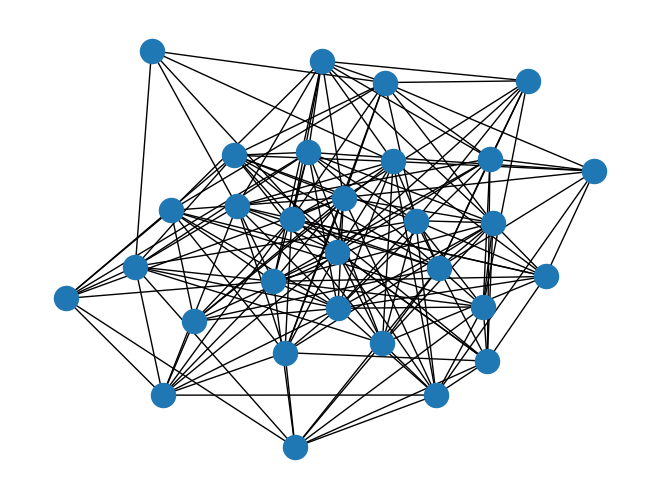

In [12]:
nx.draw(problems[30][0]["G"])

# Results: unique case

In [117]:
lines[2:][0].split()

['|0000011000000000001000100>', ':', '0.3110494E-02', '0.2800000E-02', '28']

In [118]:
nq = 25
p = 10
# samples = np.loadtxt(f"./Data/MIS/hpc_samples/{nq}/{p}/{0}.out")

with open(f"./Data/MIS/hpc_samples/{nq}/{p}/{0}.out", "r") as file:
            # Read the lines from the file
    lines = file.readlines()

# Iterate through each line and split it into columns
samples = defaultdict(int)
for line in lines[2:-1]:
    columns = line.split()
    samples[columns[0][1:-1]] += int(columns[-1])
    # suma += float(columns[7])

In [119]:
samples

defaultdict(int,
            {'0000011000000000001000100': 28,
             '0010000000001000000100100': 26,
             '0000001000000000001000100': 25,
             '0010011000001000000100100': 25,
             '0000011001000000001000100': 24,
             '0000011000001000000100100': 23,
             '0000001001000000001000100': 21,
             '0000010001000000001000100': 20,
             '0010001001000000000100100': 19,
             '0010001000001000000100100': 18,
             '0000011000000000000100100': 18,
             '0000110100000000000100000': 18,
             '0010001000000000000100100': 18,
             '0010011000000000000100100': 18,
             '0000001000000010001000000': 16,
             '0010011001000000000100100': 16,
             '0000001000001000000100100': 16,
             '0010011000001000000000100': 15,
             '0000000000001000000100100': 15,
             '0000010000001000000100100': 15,
             '0010010001000000000100100': 15,
             '001

In [159]:
lines[2:][-1]

'|0000000000000000000111101> :  0.7939935E-04  0.1000000E-03           1\n'

In [152]:
method = "hpc"
delta_betas = {"local": [0.2, 0.3,0.4, 0.5, 0.6], "hpc":[0.3,0.4,0.5,0.6]}[method]
delta_gammas = {"local": [1.5, 2.0, 2.5, 3, 3.5, 4, 4.5], "hpc":[3,3.5,4,4.5,5,5.5,6]}[method]
nqs = [25]
ps = [10,25,50,100,200]
# ps = [10,25]
cases = [0]
shots = 1000
results = np.load("./Data/MIS/results.npy", allow_pickle=True).item()
for nq in nqs:
    print(f"---------   nq = {nq}   --------")
    results[nq] = {}
    for kk in cases:
        print(f"---------   case = {kk}   --------")
        results[nq][kk] = {}
        opt_energy = round(problems[nq][kk]["opt_energy"],3)
        hamiltonian = problems[nq][kk]["ising"]
        G = problems[nq][kk]["G"]
        results[nq][kk]["energies"] = {}
        results[nq][kk]["landscape"]={}
        results[nq][kk]["best"] = {}
        for p in ps:
            best_probability = 0
            print(f"---------   p = {p}   --------")
            results[nq][kk]["energies"][p] = {}
            results[nq][kk]["landscape"][p] = {"energy":np.zeros((len(delta_betas), len(delta_gammas))), "probability":np.zeros((len(delta_betas), len(delta_gammas)))}
            nn=0
            for i, delta_beta in enumerate(delta_betas):
                for j, delta_gamma in enumerate(delta_gammas):
                    if method == "local":
                        gammas = np.arange(1, p+1) * delta_gamma/p
                        betas = np.arange(1, p+1)[::-1] * delta_beta/p
                        qc = qaoa_circ(hamiltonian, gammas, betas, nq)
                        qc = transpile(qc, backend=backend)
                        samples = backend.run(qc, shots=shots).result().get_counts()
                    else:
                        with open(f"./Data/MIS/samples_hpc/{nq}/{p}/{nn}.out", "r") as file:
                            lines = file.readlines()
                        samples = defaultdict(int)
                        for line in lines[2:]:
                            columns = line.split()
                            samples[columns[0][1:-1][::-1]] += int(columns[-1])
                        shots = 10000
                        nn += 1
                    energies = defaultdict(int)
                    mean_energy = 0
                    for sample, c in samples.items():
                        e = round(energy(sample, hamiltonian), 3)
                        energies[e] += c
                        mean_energy += e*c
                    mean_energy /= shots 
                    probability = energies[opt_energy]/shots if opt_energy in energies else 0
                    results[nq][kk]["energies"][p][(delta_beta, delta_gamma)] = energies
                    results[nq][kk]["landscape"][p]["energy"][i,j] = mean_energy
                    results[nq][kk]["landscape"][p]["probability"][i,j] = probability
                    if probability > best_probability:
                        best_probability = probability
                        results[nq][kk]["best"][p] = {"probabiliy":probability, "delta_beta":delta_beta, "delta_gamma":delta_gamma, "energy":mean_energy}
                        print(f"beta:{delta_beta} | gamma: {delta_gamma}, probability: {probability}, mean energy: {mean_energy}")
# np.save("./Data/MIS/results.npy", results)

---------   nq = 25   --------
---------   case = 0   --------
---------   p = 10   --------
beta:0.3 | gamma: 3, probability: 0.0002, mean energy: -6.137200999999974
beta:0.3 | gamma: 3.5, probability: 0.0006, mean energy: -6.065936599999971
beta:0.3 | gamma: 5, probability: 0.0009, mean energy: -5.792020199999974
beta:0.4 | gamma: 3, probability: 0.0027, mean energy: -6.36127179999998
beta:0.4 | gamma: 4, probability: 0.0037, mean energy: -6.332859600000012
beta:0.4 | gamma: 5, probability: 0.0047, mean energy: -6.221280599999997
beta:0.4 | gamma: 5.5, probability: 0.0054, mean energy: -6.124099199999981
---------   p = 25   --------
beta:0.3 | gamma: 3, probability: 0.0131, mean energy: -6.545605799999982
beta:0.3 | gamma: 3.5, probability: 0.0198, mean energy: -6.548809599999999
beta:0.3 | gamma: 4, probability: 0.022, mean energy: -6.5338675999999785
beta:0.3 | gamma: 4.5, probability: 0.0226, mean energy: -6.509800399999995
beta:0.4 | gamma: 4, probability: 0.0262, mean energy: -

In [139]:
energies

defaultdict(int,
            {np.float64(-6.688): 3456,
             np.float64(-6.812): 131,
             np.float64(-6.562): 3738,
             np.float64(-6.438): 1577,
             np.float64(-6.062): 125,
             np.float64(-6.312): 573,
             np.float64(-6.188): 230,
             np.float64(-5.938): 72,
             np.float64(-5.812): 41,
             np.float64(-5.688): 16,
             np.float64(-4.438): 3,
             np.float64(-5.562): 16,
             np.float64(-5.312): 4,
             np.float64(-5.438): 12,
             np.float64(-4.938): 1,
             np.float64(-5.188): 2,
             np.float64(-5.062): 1,
             np.float64(-4.688): 1})

In [129]:
opt_energy

np.float64(-6.812)

In [128]:
best_probability

0

In [127]:
results[25][0]["energies"]

{10: {(0.3,
   3): defaultdict(int,
              {np.float64(-5.938): 1049,
               np.float64(-6.438): 193,
               np.float64(-6.062): 885,
               np.float64(-5.562): 935,
               np.float64(-5.812): 1011,
               np.float64(-6.188): 653,
               np.float64(-5.688): 890,
               np.float64(-6.312): 381,
               np.float64(-5.188): 510,
               np.float64(-4.688): 260,
               np.float64(-5.312): 767,
               np.float64(-6.562): 39,
               np.float64(-4.938): 412,
               np.float64(-5.438): 755,
               np.float64(-4.438): 129,
               np.float64(-5.062): 425,
               np.float64(-4.812): 238,
               np.float64(-4.312): 103,
               np.float64(-4.562): 143,
               np.float64(-3.062): 7,
               np.float64(-4.188): 39,
               np.float64(-3.812): 35,
               np.float64(-3.688): 19,
               np.float64(-6.688): 2,
          

In [122]:
kk = 0 
results[nq][kk]["best"][p]

KeyError: 25

In [150]:
ps = [10,25,50,100,200]
# ps = [25]
nqs = [21]
cases = range(1, 100)
shots = 1000
results = np.load("./Data/MIS/results.npy", allow_pickle=True).item()
for nq in nqs:
    print(f"---------   nq = {nq}   --------")
    for kk in cases:
        print(f"---------   case = {kk}   --------")
        results[nq][kk] = {}
        opt_energy = round(problems[nq][kk]["opt_energy"],3)
        hamiltonian = problems[nq][kk]["ising"]
        G = problems[nq][kk]["G"]
        results[nq][kk]["best"] = {}
        for p in ps:
            if nq > 5 and nq < 21: 
                delta_gamma = np.mean([results[i][0]["best"][p]["delta_gamma"] for i in [nq-1, nq, nq+1]])
                delta_beta = np.mean([results[i][0]["best"][p]["delta_beta"] for i in [nq-1, nq, nq+1]])
            elif nq == 5:    
                delta_gamma = np.mean([results[i][0]["best"][p]["delta_gamma"] for i in [nq, nq+1]])
                delta_beta = np.mean([results[i][0]["best"][p]["delta_beta"] for i in [nq, nq+1]])
            elif nq == 21:    
                delta_gamma = np.mean([results[i][0]["best"][p]["delta_gamma"] for i in [nq-1, nq]])
                delta_beta = np.mean([results[i][0]["best"][p]["delta_beta"] for i in [nq-1, nq]])
            else:
                print("here")
            gammas = np.arange(1, p+1) * delta_gamma/p
            betas = np.arange(1, p+1)[::-1] * delta_beta/p
            qc = qaoa_circ(hamiltonian, gammas, betas, nq)
            qc = transpile(qc, backend=backend)
            samples = backend.run(qc, shots=shots).result().get_counts()
            energies = defaultdict(int)
            mean_energy = 0
            for sample, c in samples.items():
                e = round(energy(sample, hamiltonian), 3)
                energies[e] += c
                mean_energy += e*c
            mean_energy /= shots 
            probability = energies[opt_energy]/shots if opt_energy in energies else 0
            results[nq][kk]["best"][p] = {"probabiliy":probability, "delta_beta":delta_beta, "delta_gamma":delta_gamma, "energy":mean_energy}
            print(f"p:{p} | beta:{delta_beta} | gamma: {delta_gamma}, probability: {probability}, mean energy: {mean_energy}")
np.save("./Data/MIS/results.npy", results)

---------   nq = 21   --------
---------   case = 1   --------
p:10 | beta:0.5 | gamma: 4.0, probability: 0, mean energy: -0.5419959999999994


KeyboardInterrupt: 

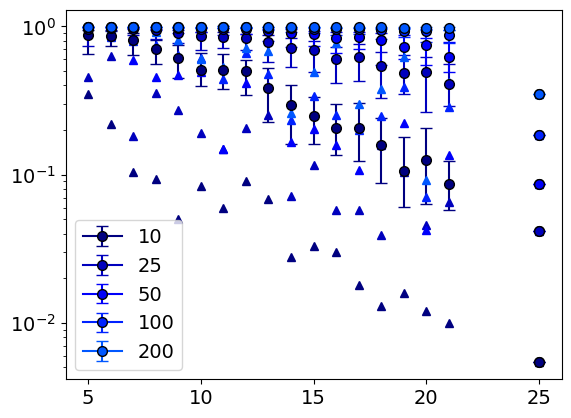

In [148]:
fig, ax  = plt.subplots()
sort = defaultdict(dict)
for i, p in enumerate([10,25,50,100,200]):
    for nq in sorted(results.keys()):
        y = [results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]
        quartiles = np.percentile(np.array(y), [25, 50, 75])
        sort[p][nq] = quartiles[1]
        ax.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(i), capsize=4, markersize=7, markeredgecolor="black")
    ax.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(i), capsize=4, markersize=7, markeredgecolor="black", label=p)

    y_min = [np.min([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    std = [np.std([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    # plt.errorbar(sorted(results.keys()), y, std , marker="o", label=p, color=colors(3*i), capsize=3)
    ax.plot(sorted(results.keys()), y_min , marker="^", linewidth=0, color=colors(i))
nqs = range(5, 20)
# plt.plot(nqs, [1/2**nq for nq in nqs], linestyle="--", color="black")
ax.legend()
ax.set_yscale("log")

Text(0.5, 0, '$p$')

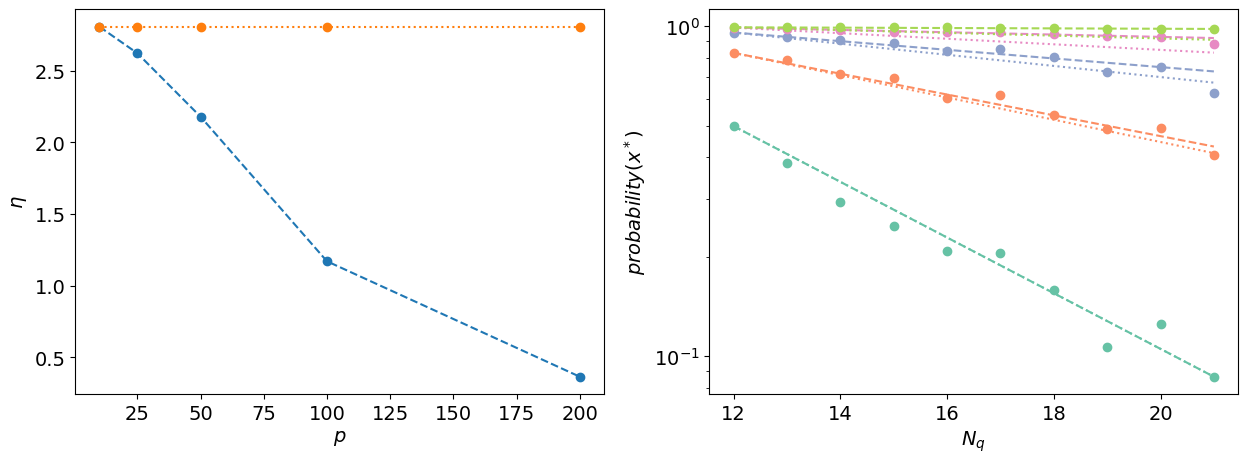

In [97]:
def func(x, p, nqs, y_real):
    """C:constant, eta:important value of the scale"""
    eta = x[0]
    C = x[1]
    y_eff = np.array([-eta*(nq - nqs[0])/p for nq in nqs])
    return (np.abs(y_eff - y_real)).mean()

colors = plt.get_cmap("Set2")
ps = [10,25,50,100,200]
etas = {}
Cs = {}
error = {}
fig, ax = plt.subplots(1,2, figsize=(15,5))
for p in ps:
    nqs = range(12,22)
    y_real = [np.log2(sort[p][nq]/sort[p][nqs[0]]) for nq in nqs]
    x0 = [0.5 , 0.1]
    sol = minimize(func, x0, args=(p, nqs, y_real))
    etas[p] = sol.x[0]
    Cs[p] = sol.x[1]
    error[p] = sol.fun

ax[0].plot(sorted(ps), [etas[p] for p in sorted(ps)], marker="o", linestyle="--")
ax[0].plot(sorted(ps), [etas[ps[0]] for p in sorted(ps)], marker="o", linestyle=":")

for i, p in enumerate(sort.keys()):
    ax[1].plot(nqs, [np.mean(sort[p][nq]) for nq in nqs], marker="o", linewidth=0, color=colors(i))
    ax[1].plot(nqs, [sort[p][nqs[0]] * 2**(-etas[p]*(nq - nqs[0])/p) for nq in nqs], linestyle="--", color=colors(i))
    ax[1].plot(nqs, [sort[p][nqs[0]] * 2**(-etas[ps[0]]*(nq - nqs[0])/p) for nq in nqs], linestyle=":", color=colors(i))

ax[1].set_yscale("log")
ax[1].set_ylabel(r"$probability(x^*)$")
ax[1].set_xlabel(r"$N_q$")
ax[0].set_ylabel(r"$\eta$")
ax[0].set_xlabel(r"$p$")
# ax[0].set_ylim(0,10)

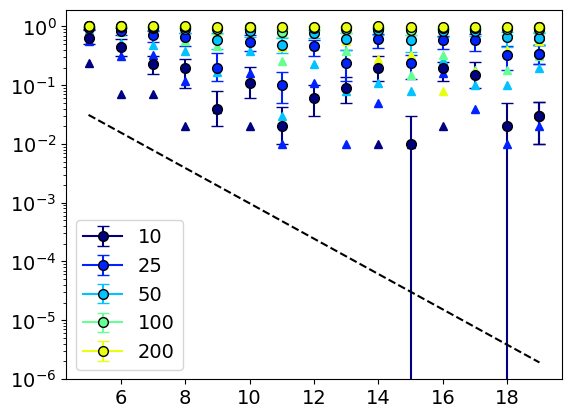

In [189]:
for i, p in enumerate([10,25,50,100,200]):
    for nq in sorted(results.keys()):
        y = [results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]
        quartiles = np.percentile(np.array(y), [25, 50, 75])
        plt.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(3*i), capsize=4, markersize=7, markeredgecolor="black")
    plt.errorbar(nq, quartiles[1], yerr=[[quartiles[1] - quartiles[0]],[quartiles[2] - quartiles[1]]], marker="o", color=colors(3*i), capsize=4, markersize=7, markeredgecolor="black", label=p)

    y_min = [np.min([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    std = [np.std([results[nq][kk]["best"][p]["probabiliy"] for kk in results[nq].keys()]) for nq in sorted(results.keys())]
    # plt.errorbar(sorted(results.keys()), y, std , marker="o", label=p, color=colors(3*i), capsize=3)
    plt.plot(sorted(results.keys()), y_min , marker="^", linewidth=0, color=colors(3*i))
nqs = range(5, 20)
plt.plot(nqs, [1/2**nq for nq in nqs], linestyle="--", color="black")
plt.legend()
plt.yscale("log")

In [156]:
results[nq][kk]["best"]

{10: {'probabiliy': 0.11,
  'delta_beta': 0.5,
  'delta_gamma': 3,
  'energy': -5.2625},
 25: {'probabiliy': 0.31,
  'delta_beta': 0.7,
  'delta_gamma': 3,
  'energy': -5.36},
 50: {'probabiliy': 0.38,
  'delta_beta': 0.4,
  'delta_gamma': 3,
  'energy': -5.5425},
 100: {'probabiliy': 0.65,
  'delta_beta': 0.4,
  'delta_gamma': 2.5,
  'energy': -5.595},
 200: {'probabiliy': 0.87,
  'delta_beta': 0.5,
  'delta_gamma': 2.5,
  'energy': -5.6575}}

Text(0, 0.5, '$\\gamma$')

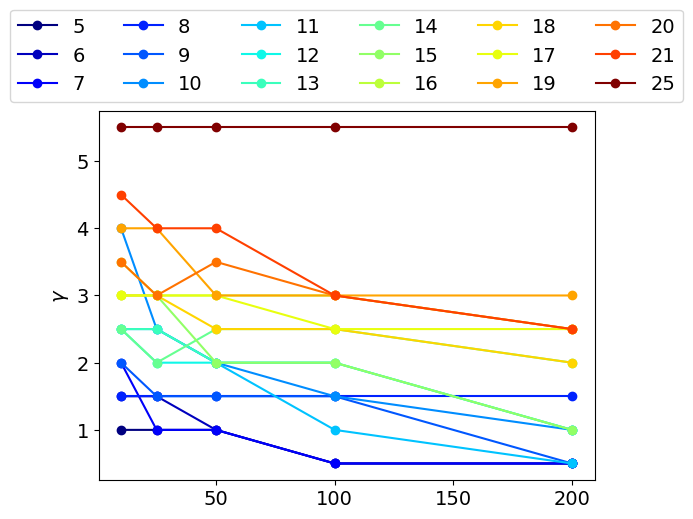

In [149]:
colors = plt.get_cmap("jet", 20)
kk = 0
for nq in results.keys():
    plt.plot(results[nq][kk]["best"].keys(), [results[nq][kk]["best"][p]["delta_gamma"] for p in results[nq][kk]["best"].keys()], marker="o",color= colors(nq-5), label=nq)
plt.legend(loc="upper center", bbox_to_anchor=(0.5,1.3), ncol=6)
plt.ylabel(r"$\gamma$")

Text(0, 0.5, '$\\beta$')

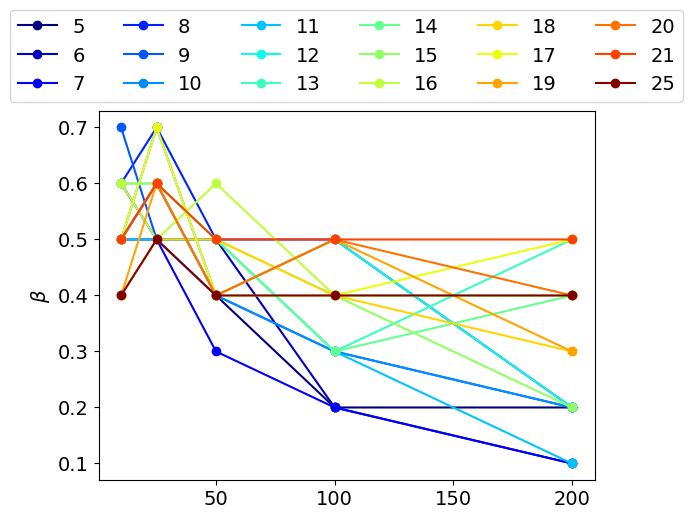

In [153]:
colors = plt.get_cmap("jet", 20)
kk = 0
for nq in results.keys():
    plt.plot(results[nq][kk]["best"].keys(), [results[nq][kk]["best"][p]["delta_beta"] for p in results[nq][kk]["best"].keys()], marker="o",color= colors(nq-5), label=nq)
plt.legend(loc="upper center", bbox_to_anchor=(0.5,1.3), ncol=6)
plt.ylabel(r"$\beta$")

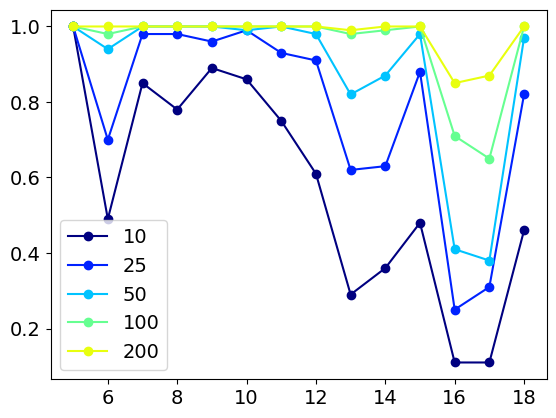

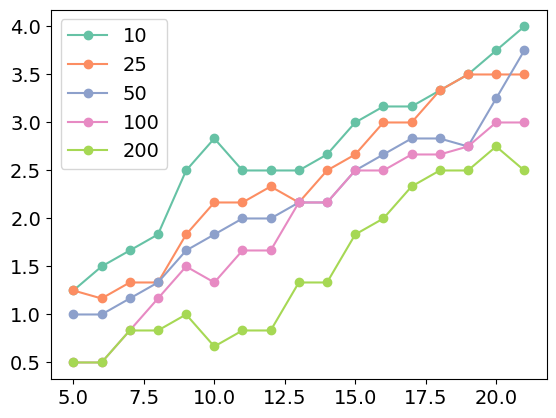

In [92]:
for i, p in enumerate(ps):
    plt.plot(sorted(results.keys()), [results[nq][kk]["best"][p]["delta_gamma"] for nq in sorted(results.keys())], marker="o", label=p, color=colors(i))
plt.legend()

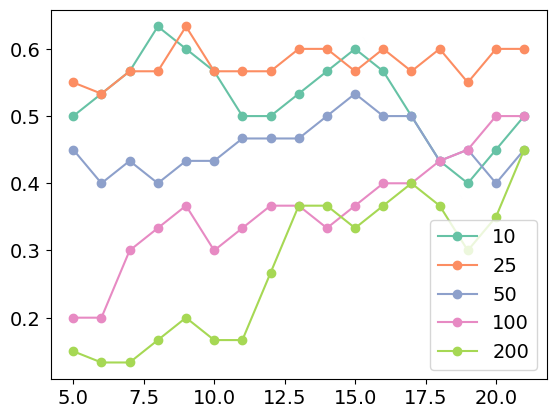

In [93]:
for i, p in enumerate(ps):
    plt.plot(sorted(results.keys()), [results[nq][kk]["best"][p]["delta_beta"] for nq in sorted(results.keys())], marker="o", label=p, color=colors(i))
plt.legend()

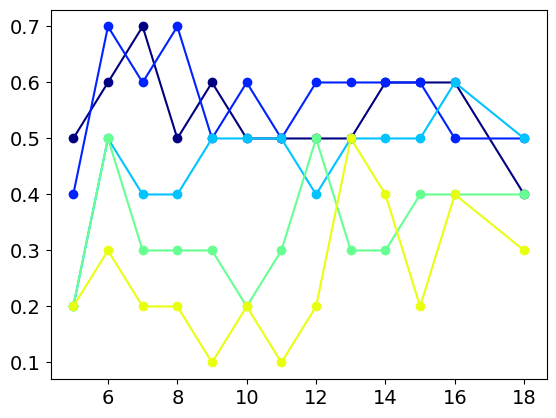

In [146]:

for i, p in enumerate(ps):
    plt.plot(results.keys(), [results[nq][kk]["best"][p]["delta_beta"] for nq in results.keys()], marker="o", label=p, color=colors(3*i))



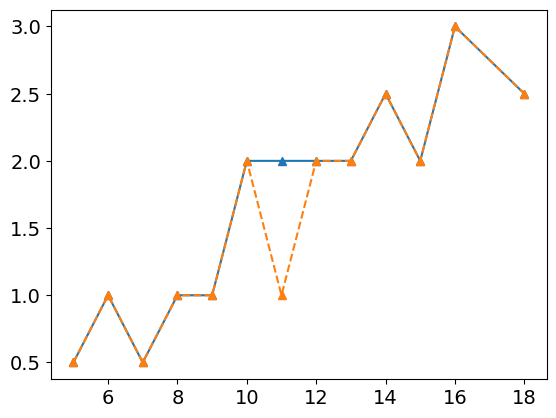

In [149]:
p=50
kk = 0
plt.plot(results.keys(), [results[nq][kk]["best"][p]["delta_gamma"] for nq in results.keys()], marker="^")
p=100
kk = 0
plt.plot(results.keys(), [results[nq][kk]["best"][p]["delta_gamma"] for nq in results.keys()], marker="^", linestyle="--")

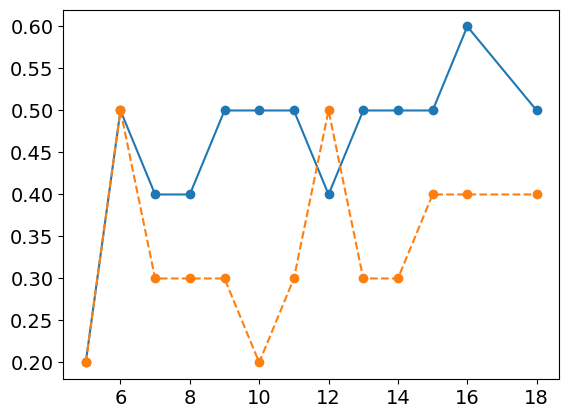

In [148]:
p=50
kk = 0
plt.plot(results.keys(), [results[nq][kk]["best"][p]["delta_beta"] for nq in results.keys()], marker="o")
p=100
kk = 0
plt.plot(results.keys(), [results[nq][kk]["best"][p]["delta_beta"] for nq in results.keys()], marker="o", linestyle="--")


In [85]:
results[nq][kk]["landscape"][p]["energy"]

array([[-5.266266, -5.253113, -5.196792, -5.156203, -5.10733 , -4.98474 ,
        -4.911587],
       [-5.270556, -5.284284, -5.28171 , -5.273988, -5.257411, -5.054265,
        -4.646544],
       [-5.245391, -5.28457 , -5.282854, -5.277998, -5.166275, -4.703126,
        -3.80368 ],
       [-5.208496, -5.283998, -5.280284, -5.228567, -5.073694, -4.118238,
        -2.830782],
       [-5.173899, -5.282282, -5.277428, -5.147417, -4.707956, -3.192761,
        -1.75957 ],
       [-5.133291, -5.281996, -5.22114 , -4.899973, -4.494245, -2.186405,
        -0.814943],
       [-5.100126, -5.278564, -5.136841, -4.709694, -3.688465, -1.258339,
        -0.206884]])

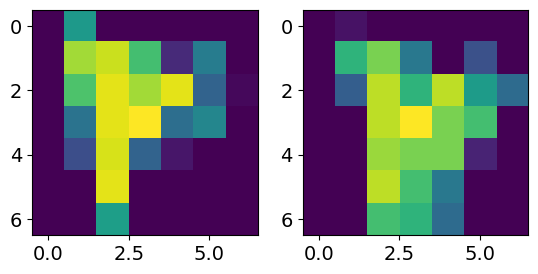

In [154]:
p = 100
nq = 18
fig, ax = plt.subplots(1,2)
ax[0].imshow(-results[nq][kk]["landscape"][p]["energy"], vmin=6, vmax=np.max(-results[nq][kk]["landscape"][p]["energy"]))
ax[1].imshow(results[nq][kk]["landscape"][p]["probability"], vmin= 0.8, vmax=np.max(results[nq][kk]["landscape"][p]["probability"]))

In [152]:
problems[nq][kk]["opt_energy"]


-6.1